# Redes Neuronales - TP1

## Ej 2

1. Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red. Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).

|$P_{error}$|${p_{max}}/{N}$|
|-|-|
|0.001|0.105|
|0.0036|0.138|
|0.01|0.185|
|0.05|0.37|
|0.1|0.61|

2. Proponga una manera de generar patrones con distintos grados de correlación.
Utilice el método propuesto para analizar cómo varía la capacidad de la red de
Hopfield en función de la correlación entre patrones.


Mi idea es crear una clase que reciba un set de probabilidades de error y un tamaño de red particular, y devuelva la capacidad para cada umbral de error. 

En lo que respecta a patrones, siempre se va a evaluar con patrones con una correlación determinada. un método los va a generar aleatoriamente, otro debería poder hacerlos con una correlación "custom". 


Una aclaración importante: el primer inciso va a parecer desprolijo en comparación con este, pero es porque en ese prioricé tener algo funcionando. Ahora que entendí un poco más es más fácil colocar todo en una clase y operar desde ahí. 

Para el inciso que genera vectores correlacionados se hace lo siguiente. Se suponen vectores X e Y generados de tal forma que toman valores discretos $-1$ y $1$ con probabilidad $1/2$. Así, sus medias son cero y las varianzas son unitarias. Se plantea el coeficiente de correlación de pearson como:

$$
corr_{coef} = \frac{cov(X,Y)}{\sqrt{Var(X)\cdot Var(Y)}} =  E[X \cdot Y] - E[X]E[Y] = E[X \cdot Y]
$$

Y ahora $E[X \cdot Y]$ se abre por esperanza total en:

$$
E[X \cdot Y] = P(X=1)P(Y=1)(1)(1) * P(X=1)P(Y=-1)(1)(-1) * P(X=-1)P(Y=1)(-1)(1) * P(X=-1)P(Y=-1)(-1)(-1)
$$

Denomino $p = P(X=Y)$ la probabilidad de que los vectores concuerden en algún bit. 

$$
E[X \cdot Y] = p - (1-p) = 2p-1
$$

Entonces:
$$
corr_{coef} = 2p-1 \Leftrightarrow p = \frac{corr_{coef} +1}{2}
$$

De esta manera se puede tomar un vector X generado como se generaría cualquier vector aleatorio y luego se genera un Y en base a la probabilidad de que concuerde con el X. Si $x=1$ se tira una moneda de probabilidad p de que $y=x$. 

In [178]:
# primero importamos numpy y algo para leer imágenes y hacer graficos
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
class evaluacion_capacidad_red_neuronal:
    def __init__(self, cantidad_neuronas):
        self.N = cantidad_neuronas
        self.W = None
        self.seed_vector = None


    def estado_aleatorio(self,correlacion=0):
        """permite generar estados para entrenar una red. devuelve una matriz lista para ser usada para calcular W"""

        N =self.N # cantidad de neuronas
        rng = np.random.default_rng()  # generador de números aleatorios

        if correlacion == 0:
            # Caso sin correlación: generamos vector completamente aleatorio
            vector = np.asarray(rng.integers(2, size=N)).reshape(-1, 1)
            return vector * 2 - 1  # de -1 a 1
        
        else:
            # Caso con correlación: generamos vector correlacionado con seed_vector
            p = (1 + correlacion) / 2  # Probabilidad de coincidir con la semilla
            
            seed_flat = self.seed_vector.flatten()
            mascara = rng.random(size=N) < p
            
            # Aplicar la regla con arrays 1D
            vector_correlacionado = np.where(mascara, seed_flat, -seed_flat)
            
            # Reconvertir a forma de columna
            return vector_correlacionado.reshape(-1, 1)


    def calcular_W(self, patrones, eta = 1):
        """
        Para calcular la W correspondiente a los patrones recibidos. Se asume que el formato es el que siempre se viene trabajando de vectores colmunas
        Se supone un "eta" unitario por comodidad. 
        """
        n_neuronas = self.N
        n_patrones = patrones.shape[1]

        X = patrones
        W = (X @ X.T - n_patrones*np.eye(n_neuronas)) * eta
        self.W = W

        return
    


    
    def step_red_neuronal(self, patron_inicial):
        """
        Patrón inicial debe ser vector columna.
        """
        estado = np.copy(patron_inicial)
        estado = self.W @ estado
        estado = np.sign(estado)
        estado = np.where(estado == 0, 1, estado)  # Manejar ceros
        return estado
        

    def agregar_columna(self, datos,correlacion=0):
        """Esto lo uso para agregar de a 1 patron a la vez y no tener que hacer muchos randoms"""
        rnd = self.estado_aleatorio(correlacion=correlacion)
        datos = np.hstack((datos, rnd))
        return datos,rnd # debería ser cómodo para cuando itere para encontrar cuando fallan las cosas
    
    def comprobar_memoria(self, original):
        salida = self.step_red_neuronal(original)
        cant_bits_erroneos = np.sum(np.abs(original-salida)/2) # si hago la diferencia y divido por 2 debería obtener 
        # la cantidad de bits diferentes porque 1+1 = 2 ,1-1 = 0 ,-1-1 = -2
        return cant_bits_erroneos
    
    def actualizar_W(self, nuevo_patron, eta=1):
        """
        Actualiza la matriz de pesos de una red de Hopfield con un nuevo patrón. para optimizar un poco
        
        Parámetros
        ----------
        W_vieja : np.ndarray
            Matriz de pesos ya entrenada (N x N).
        nuevo_patron : np.ndarray
            Patrón nuevo en forma de vector columna (N x 1), con valores en {-1, +1}.
        eta : float
            Factor de aprendizaje (default=1).
            
        Retorna
        -------
        np.ndarray
            Nueva matriz de pesos W actualizada.
        """
        W_vieja = self.W
        n_neuronas = W_vieja.shape[0]
        x = nuevo_patron.reshape((n_neuronas, 1))

        # Hebb incremental con eliminación de autoconexiones
        W_nueva = W_vieja + eta * (x @ x.T - np.eye(n_neuronas))

        self.W = W_nueva
        return

    

    def _estimar_errores_vs_patrones_correlacionados(self,correlacion, max_patron = -1):
        if max_patron == -1:
            max_patron = self.N

        lista_cant_patrones = []
        lista_errores = []
        datos = None

        for i in range(max_patron):
            if i == 0: 
                datos = self.estado_aleatorio(correlacion=0) # la semilla no requiere estar correlacionada a nada
                self.seed_vector = datos # la semilla para los proximos estados, asi todo está correlacionado
                self.calcular_W(datos) # la mete en el self
            else:
                datos,rnd = self.agregar_columna(datos,correlacion=correlacion) # rnd es el nuevo estado
                self.actualizar_W(rnd)


            # acá tenemos una matriz que va a ir aumentando en cantidad de patrones con las iteraciones
            # ahora invoco el cálculo de W
            

            # ahora lo que quiero es iterar por la cantidad de patrones en i y sumar la cantidad de errores
            errores_totales_bits = 0
            for k in range(i):
                estado_original_actual = datos[:,k] # el patrón k-ésimo
                error_actual = self.comprobar_memoria(estado_original_actual) # vamos a ir sumando
                error_actual = error_actual/(self.N * (i+1))
                errores_totales_bits = errores_totales_bits+error_actual

            lista_errores.append(errores_totales_bits)
            lista_cant_patrones.append(i+1)

        return lista_errores,lista_cant_patrones
    

    def _estimar_errores_vs_patrones_descorr(self, max_patron = -1):
        if max_patron == -1:
            max_patron = self.N

        lista_cant_patrones = []
        lista_errores = []
        datos = None # para que no lo llame unbound
        for i in range(max_patron):
            
            if i == 0: 
                datos = self.estado_aleatorio(correlacion=0)
                self.calcular_W(datos) # la mete en el self
            else:
                datos,rnd = self.agregar_columna(datos,correlacion=0) # rnd es el nuevo estado -> acá datos ya existe 
                self.actualizar_W(rnd)


            # acá tenemos una matriz que va a ir aumentando en cantidad de patrones con las iteraciones
            # ahora invoco el cálculo de W
            

            # ahora lo que quiero es iterar por la cantidad de patrones en i y sumar la cantidad de errores
            errores_totales_bits = 0
            for k in range(i):
                estado_original_actual = datos[:,k] # el patrón k-ésimo
                error_actual = self.comprobar_memoria(estado_original_actual) # vamos a ir sumando
                error_actual = error_actual/(self.N * (i+1))
                errores_totales_bits = errores_totales_bits+error_actual

            lista_errores.append(errores_totales_bits)
            lista_cant_patrones.append(i+1)

        return lista_errores,lista_cant_patrones


    def estimar_errores_vs_patrones(self, max_patron = -1, correlacion = 0):
        if correlacion == 0:
            lista_errores,lista_cant_patrones = self._estimar_errores_vs_patrones_descorr()
        else:
            lista_errores,lista_cant_patrones = self._estimar_errores_vs_patrones_correlacionados(correlacion)



        return lista_errores,lista_cant_patrones  

    def capacidad_dada_proba(self,lista_errores, lista_cant_patrones, prob_error_max):
        """
        Dada una curva de errores vs patrones, devuelve la máxima cantidad 
        de patrones que se pueden almacenar sin superar un error dado.
        
        Parámetros
        ----------
        lista_errores : list[float]
            Lista de probabilidades de error acumuladas (salida de estimar_errores_vs_patrones).
        lista_cant_patrones : list[int]
            Lista con la cantidad de patrones correspondientes.
        prob_error_max : float
            Probabilidad máxima de error permitida (ej: 0.05).
            
        Retorna
        -------
        int
            Cantidad máxima de patrones que cumple la condición.
        """
        capacidad = 0
        for err, cant in zip(lista_errores, lista_cant_patrones):
            if err <= prob_error_max:
                capacidad = cant
            else:
                break
        return capacidad
    

    def generar_patrones_correlacionados(self, cantidad, correlacion):
        """
        Genera 'cantidad' patrones binarios (-1,1) con una correlación aproximada 'correlacion' respecto a un patrón base.
        correlacion: valor entre 0 (totalmente aleatorio) y 1 (idéntico al patrón base).
        """
        N = self.N
        rng = np.random.default_rng()
        patron_base = rng.choice([-1, 1], size=(N, 1))
        patrones = [patron_base]
        p = (1 - correlacion) / 2
        for _ in range(cantidad - 1):
            ruido = rng.random((N, 1)) < p
            nuevo_patron = np.where(ruido, -patron_base, patron_base)
            patrones.append(nuevo_patron)
        return np.hstack(patrones)


In [180]:
n_neuronas = 200
ERN = evaluacion_capacidad_red_neuronal(n_neuronas) 

In [181]:
def experimento(modelo:evaluacion_capacidad_red_neuronal,correlacion, umbrales =  [0.001,0.0036,0.01,0.05,0.1],cant_redes=100):
    n_neuronas = modelo.N
    if correlacion == 0:
        errores, n_patrones = modelo.estimar_errores_vs_patrones()
    else:
        errores, n_patrones = modelo.estimar_errores_vs_patrones(correlacion=correlacion)

    errores = np.array(errores)
    for _ in range(cant_redes-1):
        err2,_ = modelo.estimar_errores_vs_patrones(correlacion=correlacion)
        errores += np.array(err2)
    errores_promediado = errores / cant_redes # promedio del error

    capacidades = []
    capacidades_norm = []
    for umbral in umbrales:
        cap = modelo.capacidad_dada_proba(errores_promediado, n_patrones, umbral)
        capacidades.append(cap)
        capacidades_norm.append(cap/n_neuronas)
    


    return errores_promediado,n_patrones,capacidades,capacidades_norm, umbrales


In [182]:
# Con paso de 0.2 (menos ejecuciones, más representativo)
resultados_00, n_patrones_00, _, capacidades_00, umbrales_00 = experimento(ERN, correlacion=0)
resultados_02, n_patrones_02, _, capacidades_02, umbrales_02 = experimento(ERN, correlacion=0.2)
resultados_04, n_patrones_04, _, capacidades_04, umbrales_04 = experimento(ERN, correlacion=0.4)
resultados_06, n_patrones_06, _, capacidades_06, umbrales_06 = experimento(ERN, correlacion=0.6)
resultados_08, n_patrones_08, _, capacidades_08, umbrales_08 = experimento(ERN, correlacion=0.8)
resultados_10, n_patrones_10, _, capacidades_10, umbrales_10 = experimento(ERN, correlacion=1.0)

In [183]:
def graficar_capacidades(umbrales, capacidades_norm, n_neuronas, correlacion=0):
    """
    Grafica la capacidad en función del umbral de error elegido.

    umbrales: lista de probabilidades de error (ej: [0.001, 0.0036, ...])
    capacidades: lista de capacidades absolutas (cantidad de patrones)
    n_neuronas: cantidad de neuronas de la red
    correlacion: valor de correlación usado (solo para título)
    """


    plt.figure(figsize=(8,6))
    plt.plot(umbrales, capacidades_norm, color="royalblue", marker='o')

    # etiquetas sobre cada punto
    for u, c in zip(umbrales, capacidades_norm):
        plt.text(u, c, f"{c:.4f}", ha='center', va='bottom', fontsize=12)

    plt.ylabel("Capacidad normalizada $p_{max}/N$")
    plt.title(f"Capacidad de red Hopfield (correlación={correlacion})")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xscale("log")
    plt.xlabel("Umbral de error permitido ($P_{error}$) [escala log]")
    plt.show()

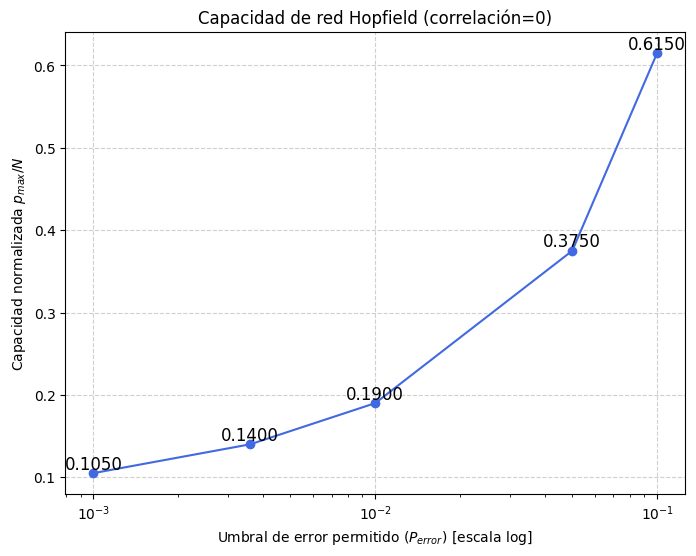

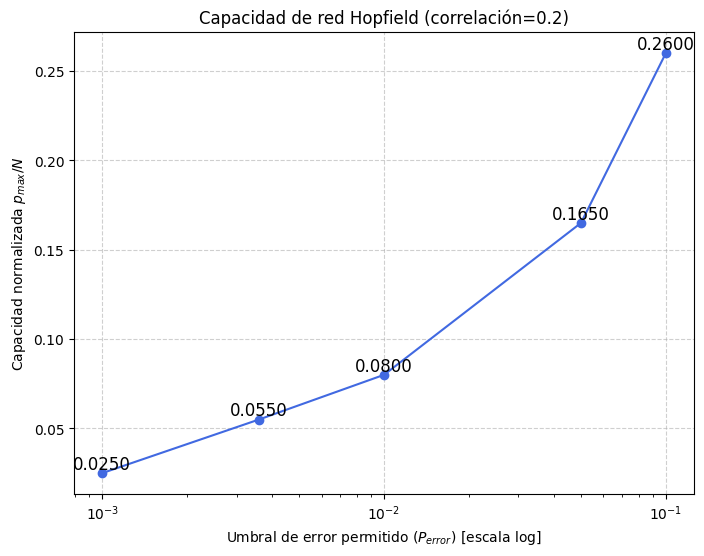

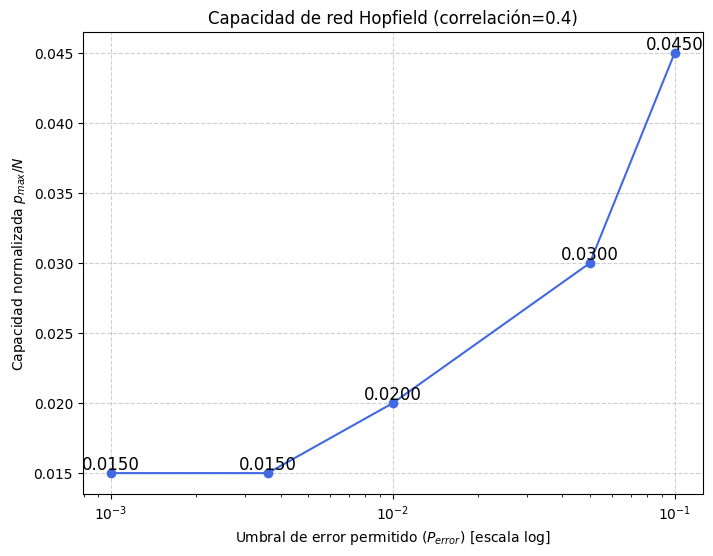

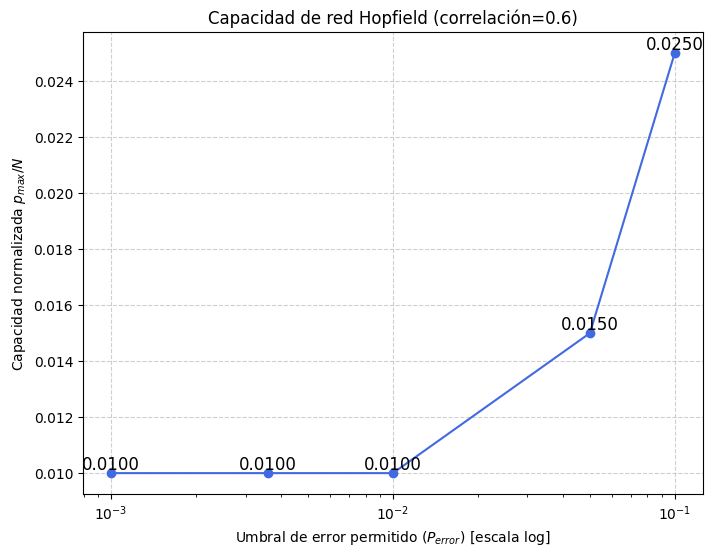

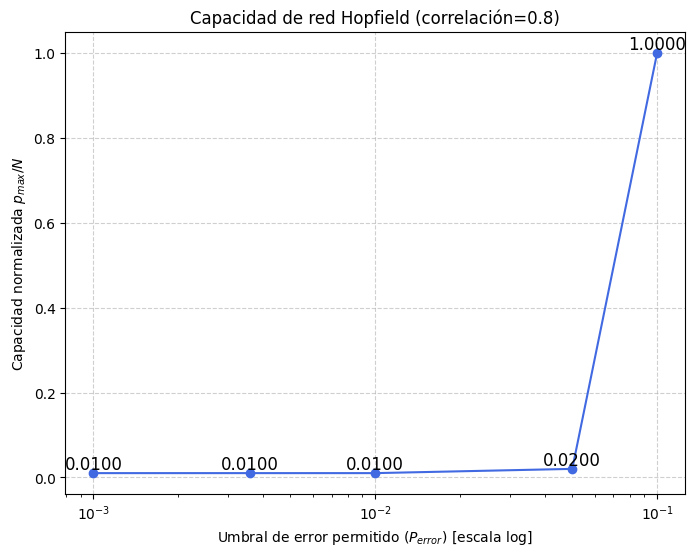

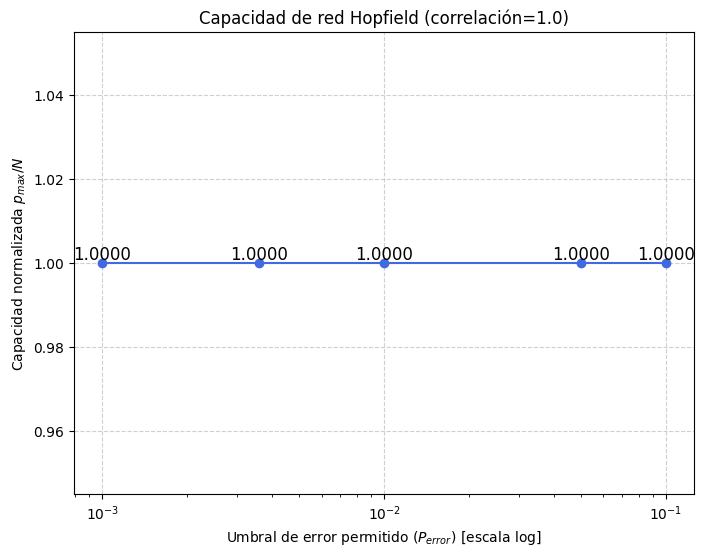

In [184]:
graficar_capacidades(umbrales_00, capacidades_00, n_neuronas, correlacion=0)
graficar_capacidades(umbrales_02, capacidades_02, n_neuronas, correlacion=0.2)
graficar_capacidades(umbrales_04, capacidades_04, n_neuronas, correlacion=0.4)
graficar_capacidades(umbrales_06, capacidades_06, n_neuronas, correlacion=0.6)
graficar_capacidades(umbrales_08, capacidades_08, n_neuronas, correlacion=0.8)
graficar_capacidades(umbrales_10, capacidades_10, n_neuronas, correlacion=1.0)


Análisis de los resultados:
Sobre el primer inciso:
Los resultados del primer gráfico, correspondiente a las capacidades por tamaño de red en función de los umbrales, es, a fines prácticos, idéntico a los datos de la tabla provistos, que son para redes con un número de neuronas tendiendo a infinito. El número no es perfectamente coincidente por un tema del tamaño de las redes que se están evaluando, aun habiendo implementado un sistema que promedia las capacidades entre muchas redes. 

Se nota que la capacidad aumenta con el umbral, lo que tiene sentido porque un aumento en el umbral equivale a mayor tolerancia de errores. 

Para el inciso 2:
Se observa la misma tendencia de antes: la capacidad aumenta con el umbral. Sin embargo, la tendencia se degenera hasta que, con correlación unitaria, el resultado indicaría que la memoria es perfecta. En realidad, lo que sucede es que las matrices W empeizan a ser entrenadas con más y más patrones repetidos, que causa que la capacidad aumente ficticiamente. Para el caso de correlación unitaria sucede que la forma de generación de vectores correlacionados termina copiandolos, la probabilidad de que los estados sean iguales termina siendo unitaria. 

Aparte, cuando todos los estados memorizados son similares (difieren por pocos bits), la red va a recordar su "esencia", y podría haber un umbral para el que los errores entre el estado que se debería haber memorizado y lo que aprendió la red (la "esencia") sean tolerables, aumentando la capacidad. Esto se ve bien para las correlaciones de 0.8 y 0.6. 

En sí, se considera que con redes más grandes los datos deberían converger a los teóricos. 